<h1 style= "color:#9370DB;"> Stock Analysis </h1>

In [1]:
# 📚 Libraries 
import kagglehub
import pandas as pd
import numpy as np
import os

# New liabraries. 
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

### The Stock Analysis Dataset:


**First impressions:**
    
_____________

The **S&P 500** is a stock market index tracking the performance of the largest 500 publicly traded companies listed on U.S. stock exchanges.

Investors have long used the S&P 500 as a benchmark for their investments as it tends to signal overall market health. 
The index is a popular choice for long-term inverstors who wish to watch growth over the coming deacades. 

The dataset contains: 
- S&P 500 **Index**: Contains the daily price of the index, representing the overall performance of the 500 companies in the S&P 500.
- S&P 500 **Stocks**: Includes the daily stock prices for each company within the index, providing insights into individual stock movements. 
- S&P 500 **Companies**: Provides detailed information about each company, including metrics such as Name, Sector, Marketcap, Ebitda, Weight.

The data types are even: (13 int or float / 13 objects).

Our **project goal** is to identify the performance of various sectors in the S&P 500. After reading the [documentation](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks) we will proceed with the following **strategy**:

1. The **target** of our dataset will be `currentprice`, which is the actual price of the stock right now.
2. Through **Exploratory Data Analysis** we will identify the features that contribute to this prediction.


_____________

<h2 style="color: #9370DB;"> 01 | Data Extraction </h2>

In [2]:
data = pd.read_csv('sp500_stocks.csv')
df = pd.read_csv('sp500_companies.csv')
sp = pd.read_csv('sp500_index.csv')

In [3]:
# Cleaning columns with snake_case 
data.columns = [col.lower().replace(" ", "_")for col in data.columns] 
df.columns = [col.lower().replace(" ", "_")for col in df.columns] 
sp.columns = [col.lower().replace(" ", "_")for col in sp.columns] 

<h3 style="color: #4169E1;">1.1 | Exploring the Data </h3>

In [4]:
data.sample(3)

,date,symbol,adj_close,close,high,low,open,volume
1511646,2013-09-13,ROK,88.037422,105.040001,105.239998,104.080002,104.559998,412400.0
744377,2011-03-03,FI,15.525000,15.525000,15.642500,15.492500,15.535000,5217600.0
1577370,2020-12-31,SNA,166.076065,171.139999,171.389999,169.289993,170.360001,287800.0


In [5]:
df.sample(3)

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,city,state,country,fulltimeemployees,longbusinesssummary,weight
352,NYQ,WY,Weyerhaeuser Company,Weyerhaeuser Company,Real Estate,REIT - Specialty,31.29,22734751744,1.234000e+09,-0.169,Seattle,WA,United States,9300.0,"Weyerhaeuser Company, one of the world's large...",0.000400
26,NMS,TMUS,"T-Mobile US, Inc.","T-Mobile US, Inc.",Communication Services,Telecom Services,243.78,282904231936,3.066400e+10,0.047,Bellevue,WA,United States,67000.0,"T-Mobile US, Inc., together with its subsidiar...",0.004978
319,NYQ,SYF,Synchrony Financial,Synchrony Financial,Financial Services,Credit Services,67.92,26444242944,NaN,0.116,Stamford,CT,United States,20000.0,"Synchrony Financial, together with its subsidi...",0.000465


In [6]:
sp.sample(3)

,date,s&p500
2450,2024-09-04,5520.07
2354,2024-04-17,5022.21
1519,2020-12-18,3709.41


### The Stock Analysis Dataset: CHANGE


**First impression:**
    
_____________

The following dataset is a collection of **one-year** 18.539 player information distributed among 89 different columns. The majority of our data types are mostly **numericals** (71 integers / 18 objects).

Our **project goal** is to identify players who have the potential to become **the next "Mbappé"**. After reading the [documentation](https://www.kaggle.com/datasets/ekrembayar/fifa-21-complete-player-dataset?select=fifa21_male2.csv) we wil proceed with the following **strategy**:

1. The **target** of our dataset will be `Overall Score`, which is a summary of a player's performance and potential. 
2. Through **Exploratory Data Analysis** we will identify the features that contribute to this prediction.

_____________

### The Stock Analysis Dataset: CHANGE

- **Introduction**: Ronald A. Fisher in 1936 to demonstrate Linear Discriminant Analysis (LDA).
- **Type**: Multiclass classification dataset, ideal for supervised and unsupervised learning.
- **Features**: 
  - 4 numerical features: Sepal Length, Sepal Width, Petal Length, Petal Width.
  - Measurements describe physical dimensions of iris flowers.
- **Classes**: 3 flower species – Setosa, Versicolor, Virginica (50 samples each, 150 total).
- **Importance**:
  - Widely used for teaching classification, clustering, PCA, and visualization techniques.
  - Simple, clean, and balanced, making it ideal for learning machine learning concepts.
- **Applications**: Benchmarking algorithms like KMeans, Decision Trees, and Logistic Regression.

<h3 style="color: #4169E1;">1.2 | Copies</h3>

In [7]:
data2 = data.copy()
df2 = df.copy()
sp2 = sp.copy()

<h2 style="color: #9370DB;"> 02 | ⚒️ Data Cleaning </h2>

<h3 style="color: #4169E1;"> 2.1 | Dealing with Data types</h3>

In [8]:
data.dtypes

date          object
symbol        object
adj_close    float64
close        float64
high         float64
low          float64
open         float64
volume       float64
dtype: object

In [9]:
df.dtypes

exchange                object
symbol                  object
shortname               object
longname                object
sector                  object
industry                object
currentprice           float64
marketcap                int64
ebitda                 float64
revenuegrowth          float64
city                    object
state                   object
country                 object
fulltimeemployees      float64
longbusinesssummary     object
weight                 float64
dtype: object

In [10]:
sp.dtypes

date       object
s&p500    float64
dtype: object

<h3 style="color: #4169E1;"> 2.2 | Dealing with NaN values</h3>

In [11]:
df.isna().sum()

exchange                0
symbol                  0
shortname               0
longname                0
sector                  0
industry                0
currentprice            0
marketcap               0
ebitda                 29
revenuegrowth           3
city                    0
state                  20
country                 0
fulltimeemployees       9
longbusinesssummary     0
weight                  0
dtype: int64

In [12]:
sp.isna().sum()

date      0
s&p500    0
dtype: int64

In [13]:
data.isna().sum()

date              0
symbol            0
adj_close    101626
close        101626
high         101626
low          101626
open         101626
volume       101626
dtype: int64

In [14]:
# Delete NaN. TELL WHY I'M dropping 
data2.dropna(how='any', inplace=True)

In [15]:
data2.isna().sum()

date         0
symbol       0
adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64

In [16]:
# Use this as a reference conunting the same dproing them that without droping them. 
data2.symbol.value_counts()

symbol
MMM     3758
MHK     3758
NTAP    3758
NDAQ    3758
MSCI    3758
        ... 
VLTO     297
SOLV     175
GEV      175
SW       108
AMTM      53
Name: count, Length: 503, dtype: int64

<h3 style="color: #4169E1;"> 2.3 | Dealing with Duplicates</h3>

In [17]:
data2.duplicated().sum()

0

In [18]:
df.duplicated().sum()

0

In [19]:
sp.duplicated().sum()

0

<h3 style="color: #4169E1;"> 2.5 | Dealing with outliers</h3>

In [ ]:
def outlier_slayer(data): 
    """
    Automatically removes outliers based on Q1, Q3
    """
    for column in data.select_dtypes(include=[np.number]):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

In [ ]:
df = outlier_slayer(df, "price")

<h3 style="color: #4169E1;"> 2.6 | Moving target to the right </h3>

<h3 style="color: #4169E1;"> 2.7 | Other Steps </h3>

In [20]:
# Delete Columns 
data2.drop(columns=['high', 'low', 'open','close'], inplace=True)

In [21]:
# Change to datetime. 
data2['date'] = pd.to_datetime(data2['date'])

In [22]:
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day

In [23]:
cols = ['year', 'month', 'day', 'symbol', 'adj_close', 'volume']
data2 = data2[cols]
data2.head(3)

,year,month,day,symbol,adj_close,volume
0,2010,1,4,MMM,43.783867,3640265.0
1,2010,1,5,MMM,43.509628,3405012.0
2,2010,1,6,MMM,44.126682,6301126.0


In [24]:
# Drop rows where year is between 2010 and 2013 because SP500 for comparison we do have 2014. 
data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)

In [25]:
# Chat helped. 
annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_4766/292607746.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)


In [26]:
pivoted_df = annual_returns.pivot(index='symbol', columns='year', values='annual_return')

In [27]:
pivoted_df.sample(3)

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
PPG,-0.1272,-0.0174,0.2459,-0.1189,0.3351,0.1166,0.2377,-0.2491,0.2014,-0.1296
A,0.0418,0.1319,0.4535,0.0072,0.3098,0.3875,0.3512,-0.0374,-0.0666,0.0183
TXT,-0.0019,0.1725,0.1509,-0.1961,-0.0307,0.0650,0.6665,-0.0726,0.1446,0.0277


In [28]:
pivoted_df = pivoted_df.rename(columns={2015: 'ar_2015',2016:'ar_2016',2017: 'ar_2017', 
                                          2018:'ar_2018', 2019: 'ar_2019',2020: 'ar_2020', 2021: 'ar_2021', 2022:'ar_2022', 2023:'ar_2023',2024: 'ar_2024'})

In [29]:
cols = ['exchange', 'symbol', 'shortname','longname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'longbusinesssummary', 'weight', 'mean_2015', 'mean_2016', 'mean_2017', 'mean_2018', 'mean_2019',
        'mean_2020', 'mean_2021', 'mean_2022', 'mean_2023', 'mean_2024', 'currentprice']

In [30]:
definitive = pd.merge (df, pivoted_df, on='symbol')
definitive

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,...,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,242.84,3670720643072,1.346610e+11,0.061,...,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,142.44,3488355713024,6.118400e+10,1.224,...,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,443.57,3297889746944,1.365520e+11,0.160,...,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,227.03,2387220627456,1.115830e+11,0.110,...,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,176.49,2149065949184,1.234700e+11,0.151,...,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,33.80,7392059904,1.882000e+09,-0.048,...,-0.2022,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471
499,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,187.95,7354351616,1.071000e+09,-0.024,...,0.1491,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620
500,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,56.58,7063221248,7.033000e+08,0.085,...,-0.3028,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023
501,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,68.33,6459010048,6.731300e+08,-0.052,...,-0.2770,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726


In [31]:
cols = ['exchange', 'symbol', 'shortname','longname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'longbusinesssummary', 'weight', 'ar_2015', 'ar_2016', 'ar_2017', 'ar_2018', 'ar_2019',
        'ar_2020', 'ar_2021', 'ar_2022', 'ar_2023', 'ar_2024', 'currentprice']

In [32]:
definitive = definitive[cols]

In [54]:
df.nunique()

exchange                 4
symbol                 503
shortname              500
longname               500
sector                  11
industry               114
currentprice           500
marketcap              503
ebitda                 470
revenuegrowth          260
city                   236
state                   41
country                  8
fulltimeemployees      388
longbusinesssummary    500
weight                 503
dtype: int64

In [53]:
df.sector.value_counts()

sector
Technology                82
Industrials               70
Financial Services        67
Healthcare                63
Consumer Cyclical         55
Consumer Defensive        37
Utilities                 32
Real Estate               31
Communication Services    22
Energy                    22
Basic Materials           22
Name: count, dtype: int64

<h2 style="color: #9370DB;"> 03 | EDA (Exploratory Data Analysis) </h2>

<h3 style="color: #4169E1;"> Optional | Selecting Numerical </h3>

In [33]:
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

,exchange,symbol,shortname,longname,sector,industry,city,state,country,longbusinesssummary
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,Cupertino,CA,United States,"Apple Inc. designs, manufactures, and markets ..."
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,Santa Clara,CA,United States,NVIDIA Corporation provides graphics and compu...
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,Redmond,WA,United States,Microsoft Corporation develops and supports so...
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,Seattle,WA,United States,"Amazon.com, Inc. engages in the retail sale of..."
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,Mountain View,CA,United States,Alphabet Inc. offers various products and plat...


In [34]:
num = definitive.select_dtypes(include='number')
num.head(5)

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,3670720643072,1.346610e+11,0.061,164000.0,0.064589,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,3488355713024,6.118400e+10,1.224,29600.0,0.061381,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,3297889746944,1.365520e+11,0.160,228000.0,0.058029,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,2387220627456,1.115830e+11,0.110,1551000.0,0.042005,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,2149065949184,1.234700e+11,0.151,181269.0,0.037815,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49


<h3 style="color: #4169E1;">3.1 | Descriptive Statistics </h3>

In [35]:
definitive.describe()

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
count,5.030000e+02,4.740000e+02,500.000000,4.940000e+02,503.000000,475.000000,480.000000,482.000000,485.000000,491.000000,495.000000,495.000000,497.000000,499.000000,503.000000,503.000000
mean,1.129853e+11,7.031397e+09,0.070484,5.774496e+04,0.001988,0.045306,0.197734,0.258852,-0.034976,0.352786,0.192008,0.328778,-0.085353,0.195019,0.215239,230.293300
std,3.399129e+11,1.622777e+10,0.180071,1.394693e+05,0.005981,0.253423,0.277769,0.260448,0.225112,0.317066,0.548745,0.295113,0.279833,0.356690,0.382605,521.997583
min,5.637307e+09,-3.991000e+09,-0.602000,2.800000e+01,0.000099,-0.753000,-0.710600,-0.430800,-0.576200,-0.543300,-0.580300,-0.350500,-0.710700,-0.480700,-0.652500,8.560000
25%,2.036663e+10,1.623194e+09,0.002000,1.020000e+04,0.000358,-0.107050,0.047800,0.094325,-0.192900,0.185550,-0.051000,0.131250,-0.266900,-0.028700,0.004500,71.545000
50%,3.803281e+10,2.941705e+09,0.050000,2.159500e+04,0.000669,0.040700,0.177950,0.223250,-0.037800,0.328700,0.123900,0.306900,-0.114600,0.127500,0.167400,126.820000
75%,8.419720e+10,6.017250e+09,0.109000,5.476225e+04,0.001482,0.177300,0.310375,0.386175,0.093100,0.478200,0.302250,0.472350,0.057700,0.324050,0.371450,239.190000
max,3.670721e+12,1.495470e+11,1.632000,2.100000e+06,0.064589,1.722800,3.093900,1.427200,1.065900,4.311000,7.200500,1.900200,1.071300,2.461000,3.604300,8946.330000


In [36]:
frequ = cat.sector.value_counts()
frequ

sector
Technology                82
Industrials               70
Financial Services        67
Healthcare                63
Consumer Cyclical         55
Consumer Defensive        37
Utilities                 32
Real Estate               31
Communication Services    22
Energy                    22
Basic Materials           22
Name: count, dtype: int64

In [37]:
table = cat.sector.value_counts(normalize=True).round(2)
table

sector
Technology                0.16
Industrials               0.14
Financial Services        0.13
Healthcare                0.13
Consumer Cyclical         0.11
Consumer Defensive        0.07
Utilities                 0.06
Real Estate               0.06
Communication Services    0.04
Energy                    0.04
Basic Materials           0.04
Name: proportion, dtype: float64

In [38]:
frequency_table = pd.concat([frequ,table], axis = 1)
frequency_table


,count,proportion
sector,,
Technology,82,0.16
Industrials,70,0.14
Financial Services,67,0.13
Healthcare,63,0.13
Consumer Cyclical,55,0.11
Consumer Defensive,37,0.07
Utilities,32,0.06
Real Estate,31,0.06
Communication Services,22,0.04


<h3 style="color: #4169E1;"> 3.2 | Checking Distributions</h3>

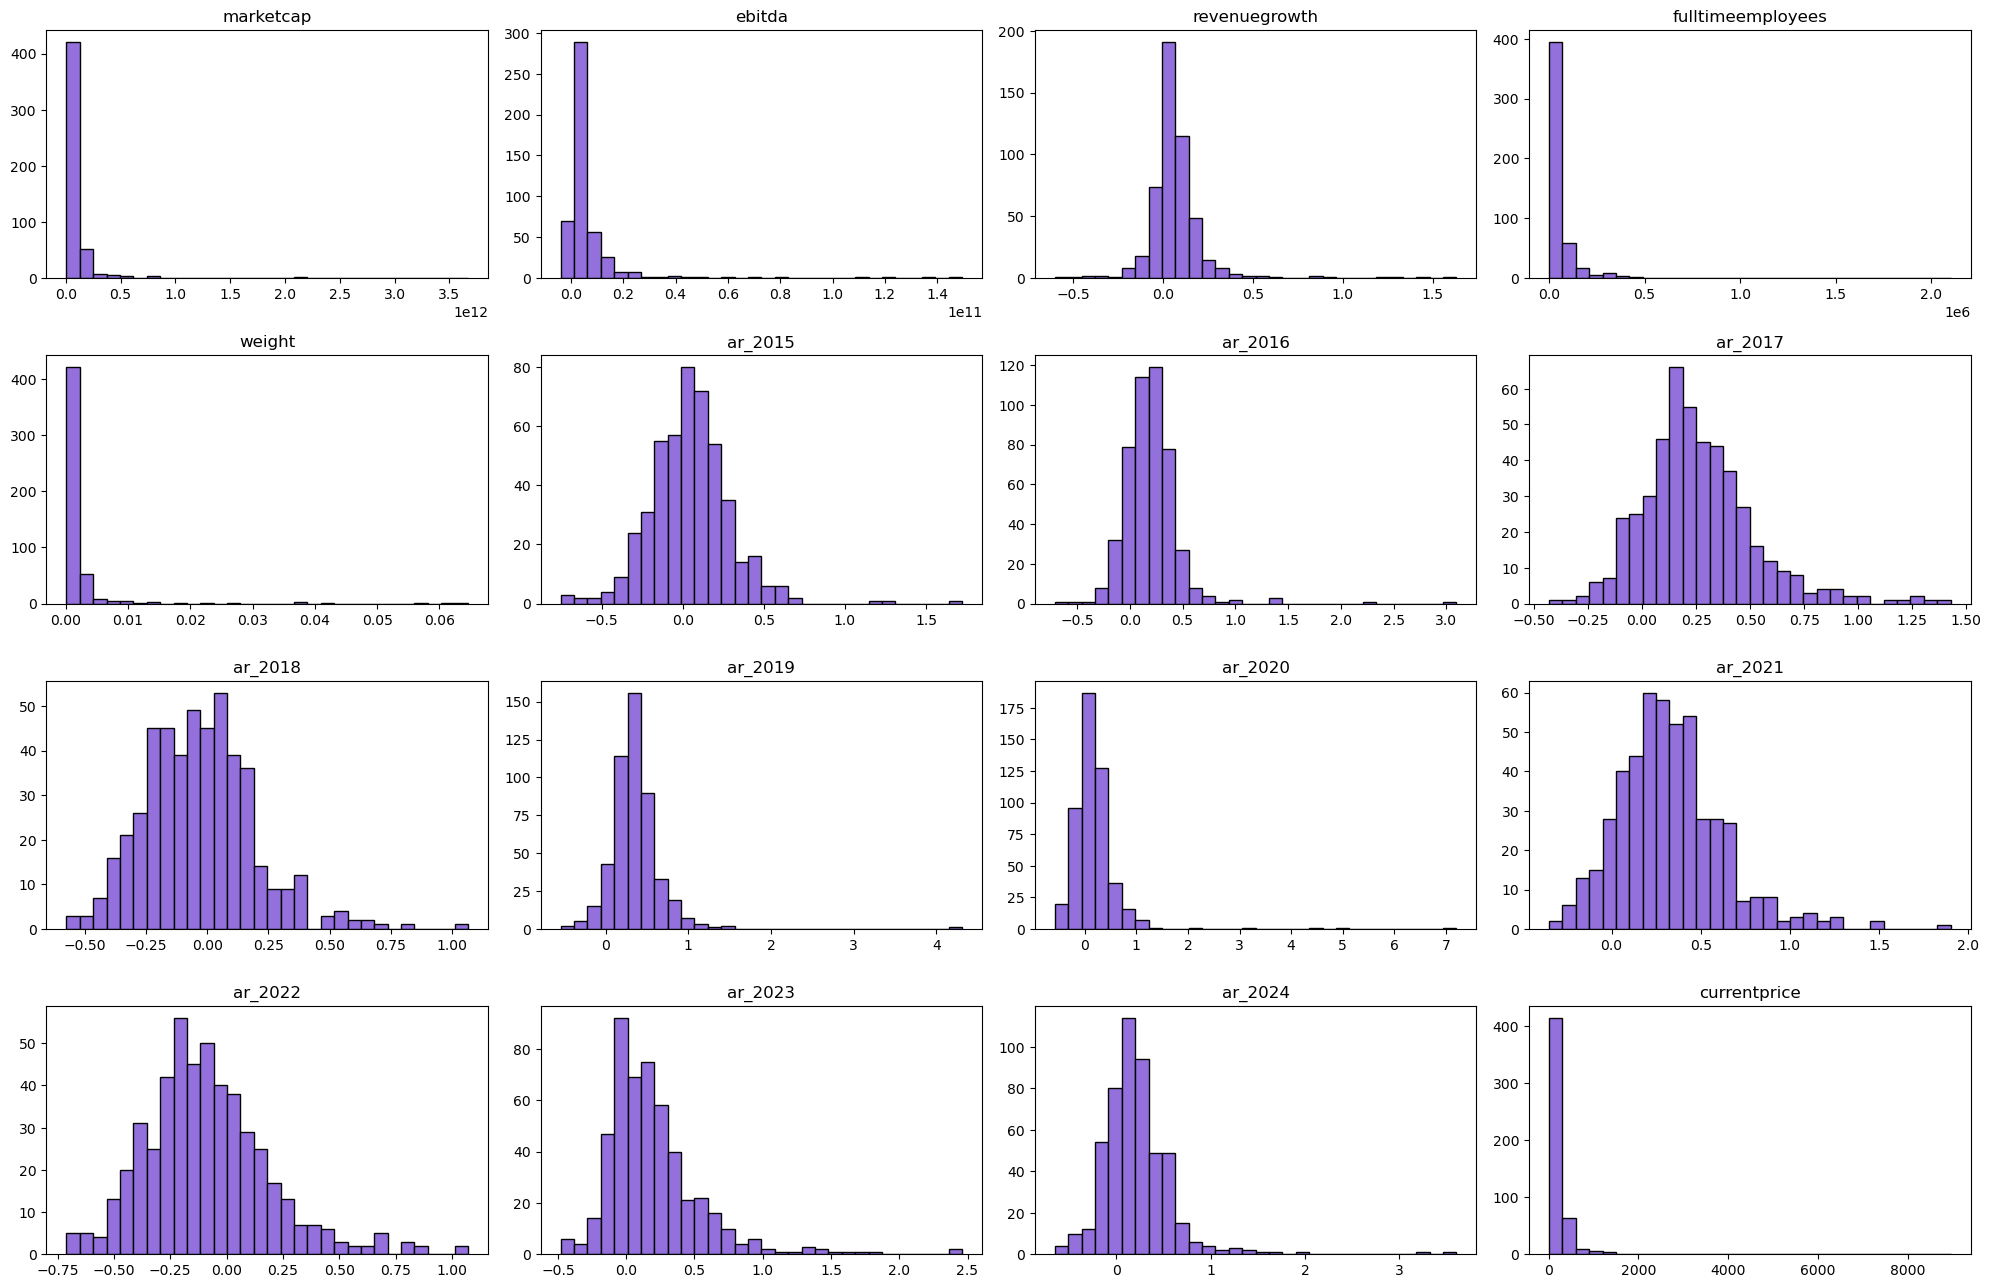

In [40]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;"> 3.3 | Checking our target distribution</h3>

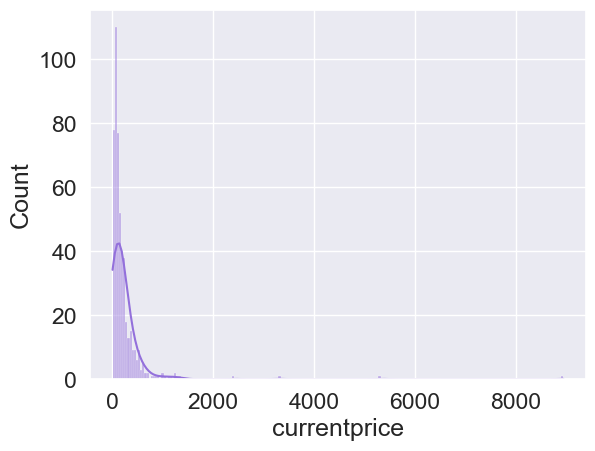

In [50]:
# Without the filter 650.000 and taking out the outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

In [49]:
#pearson 
num.corrwith(definitive['currentprice']).sort_values(ascending=False)

currentprice         1.000000
ar_2023              0.162822
ar_2017              0.154411
ar_2015              0.126672
ar_2024              0.114593
ar_2019              0.085672
ar_2018              0.055847
ar_2020              0.044220
weight               0.043058
marketcap            0.043058
revenuegrowth        0.042384
ar_2021              0.033497
ar_2022              0.016112
ebitda               0.012511
ar_2016             -0.005434
fulltimeemployees   -0.007618
dtype: float64

In [43]:
#Spearman
num.corrwith(df['currentprice'], method='spearman').sort_values(ascending=False)[:5]

currentprice    1.000000
ar_2023         0.398856
marketcap       0.384317
weight          0.384317
ar_2020         0.331854
dtype: float64

<h3 style="color: #4169E1;">3.4 | Checking Outliers </h3>

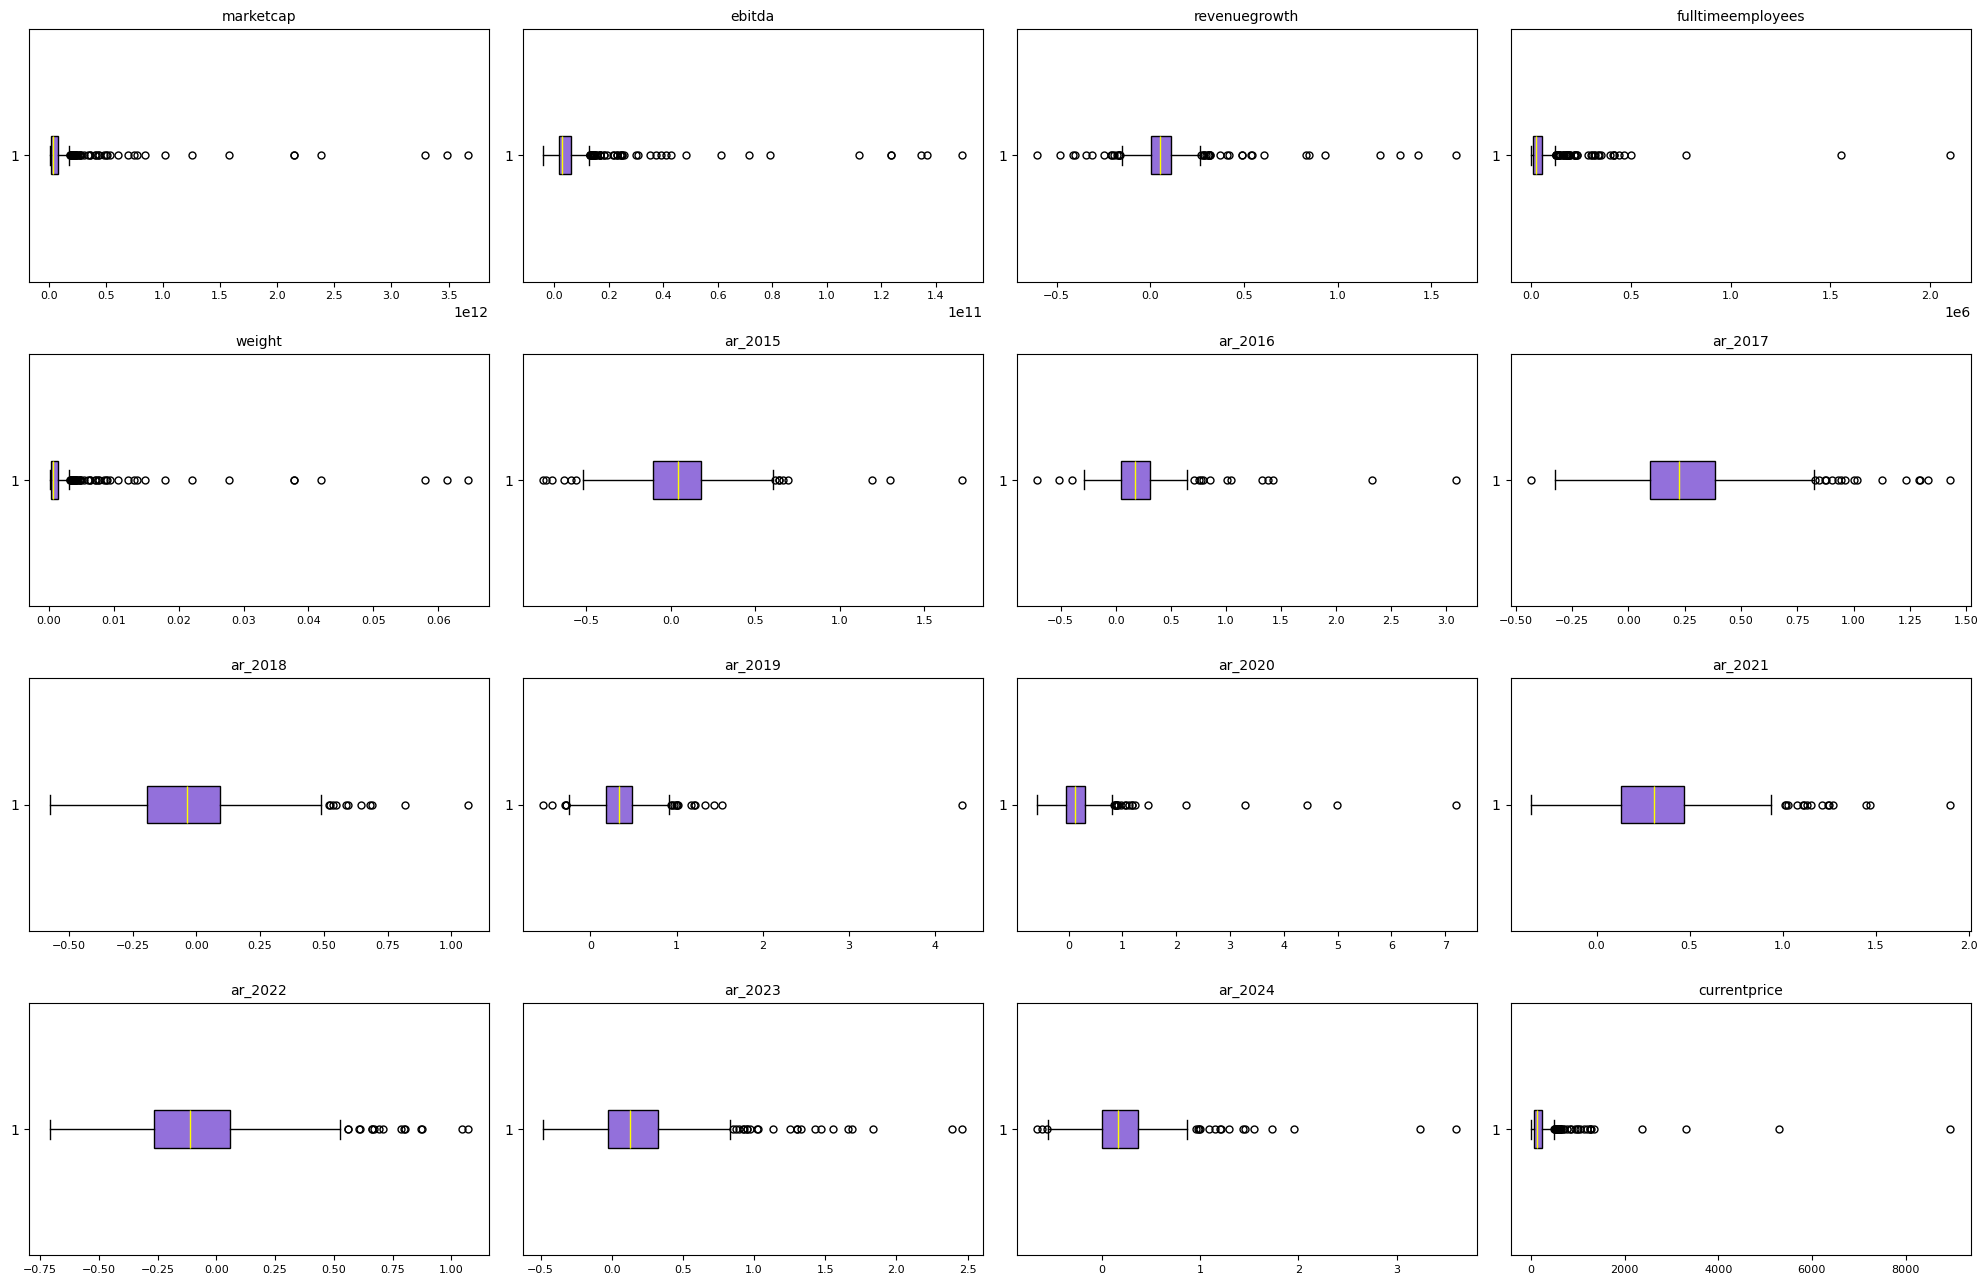

In [44]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

<h3 style="color: #4169E1;">3.5 | Looking for Correlations </h3>

In [45]:
num_corr = num.corr()
num_corr

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
marketcap,1.000000,0.849854,0.172996,0.342759,1.000000,0.193249,0.133161,0.137484,0.054559,0.063605,0.186006,0.103474,-0.123427,0.324378,0.185855,0.043058
ebitda,0.849854,1.000000,0.065370,0.403609,0.849854,0.119077,0.041054,0.027409,0.015690,-0.028116,0.017388,0.045742,-0.010294,0.146314,0.086087,0.012511
revenuegrowth,0.172996,0.065370,1.000000,-0.012331,0.172996,0.025595,0.152692,0.007961,0.061084,0.049525,0.060937,0.044603,-0.052831,0.367474,0.290595,0.042384
fulltimeemployees,0.342759,0.403609,-0.012331,1.000000,0.342759,0.082417,-0.046925,0.030057,0.005134,-0.035903,0.019590,-0.046901,-0.064023,0.039286,0.052600,-0.007618
weight,1.000000,0.849854,0.172996,0.342759,1.000000,0.193249,0.133161,0.137484,0.054559,0.063605,0.186006,0.103474,-0.123427,0.324378,0.185855,0.043058
ar_2015,0.193249,0.119077,0.025595,0.082417,0.193249,1.000000,-0.183902,0.140647,0.153540,0.012923,0.043814,-0.066283,-0.186867,0.114196,-0.065059,0.126672
ar_2016,0.133161,0.041054,0.152692,-0.046925,0.133161,-0.183902,1.000000,-0.021926,-0.062520,0.041836,-0.005660,0.164782,0.014437,0.156432,0.194349,-0.005434
ar_2017,0.137484,0.027409,0.007961,0.030057,0.137484,0.140647,-0.021926,1.000000,0.075360,0.312346,0.341680,-0.049351,-0.253892,0.228618,0.021337,0.154411
ar_2018,0.054559,0.015690,0.061084,0.005134,0.054559,0.153540,-0.062520,0.075360,1.000000,0.195853,0.195536,-0.055778,-0.091503,-0.032025,0.041198,0.055847
ar_2019,0.063605,-0.028116,0.049525,-0.035903,0.063605,0.012923,0.041836,0.312346,0.195853,1.000000,0.372098,-0.005062,-0.180804,0.133228,-0.027572,0.085672


Text(0.5, 1.0, 'Correlation Heatmap')

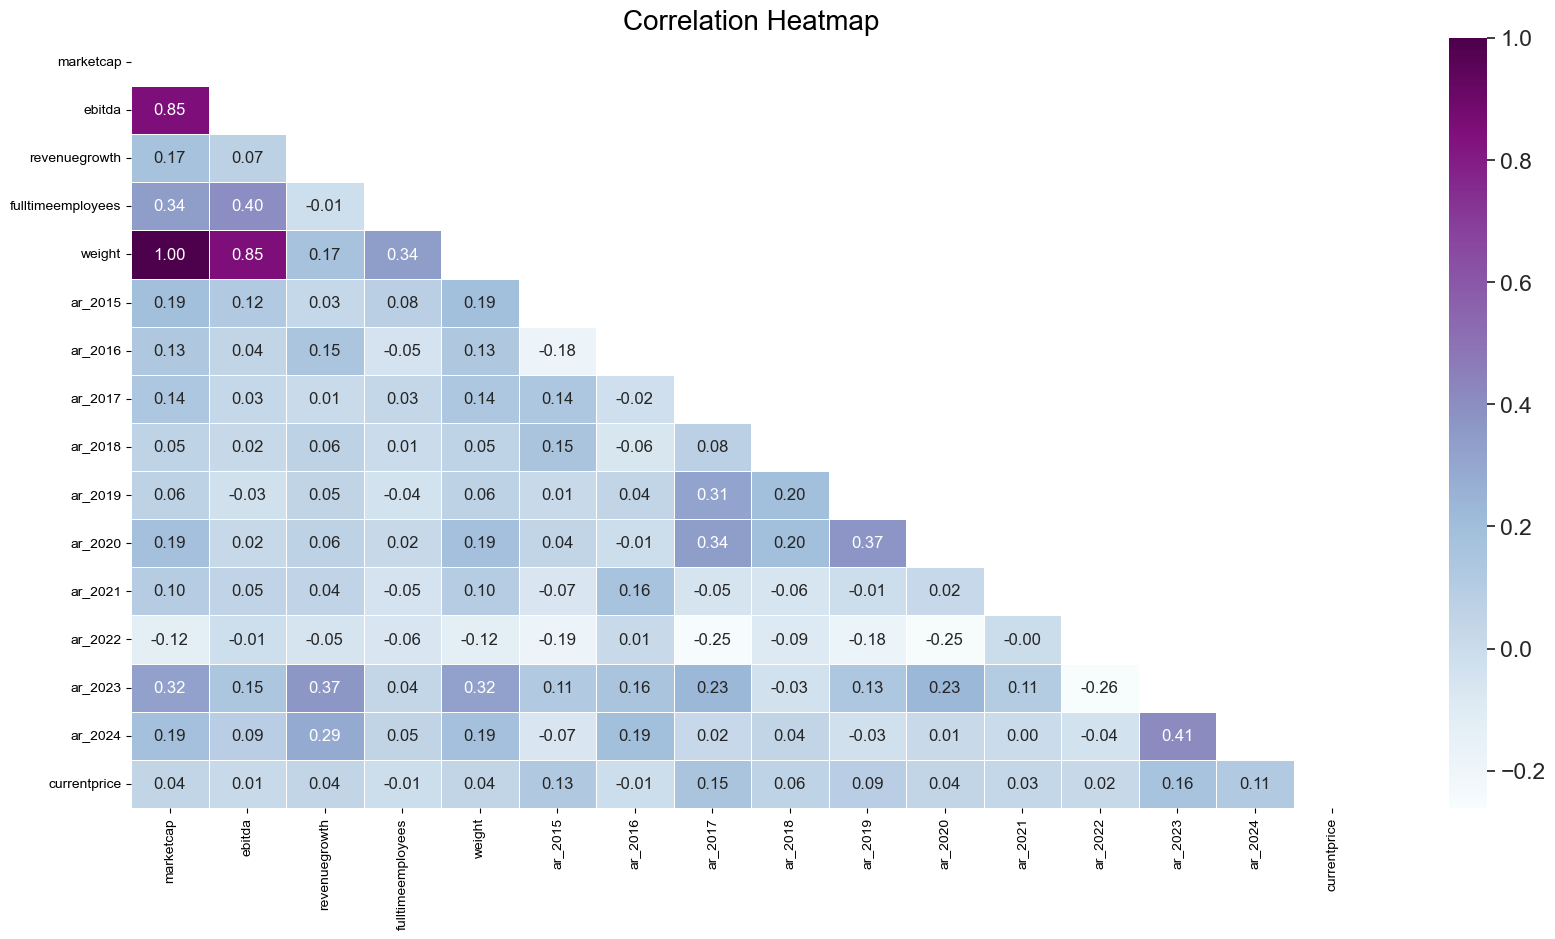

In [46]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

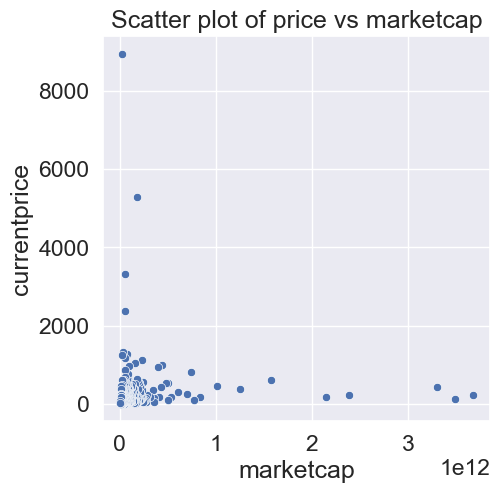

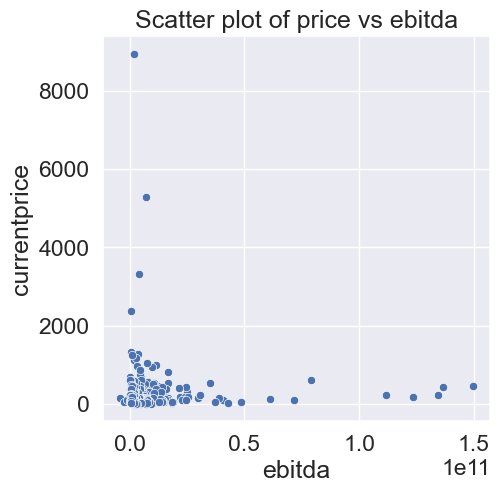

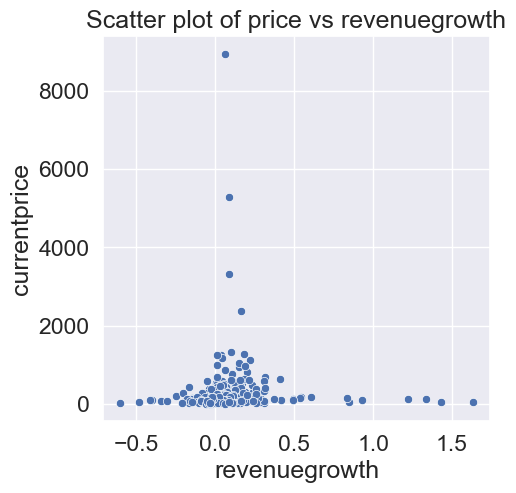

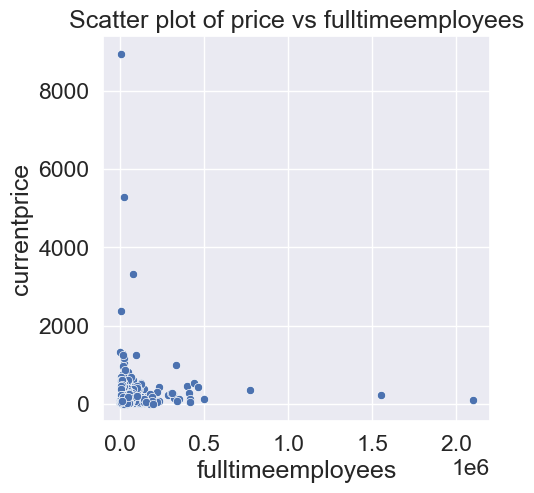

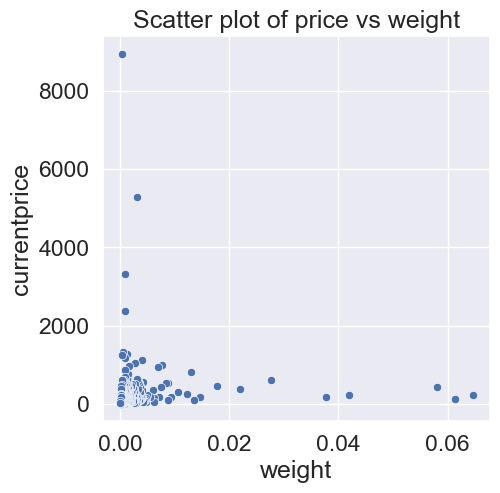

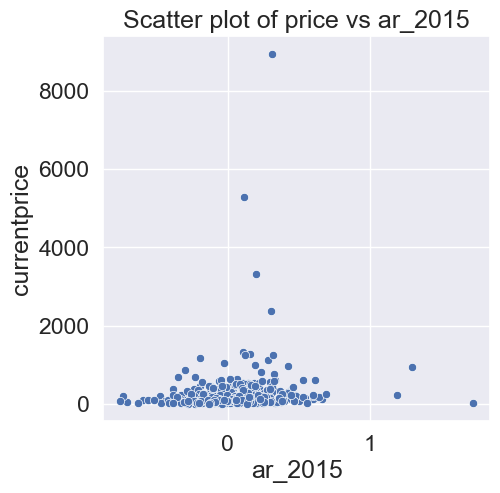

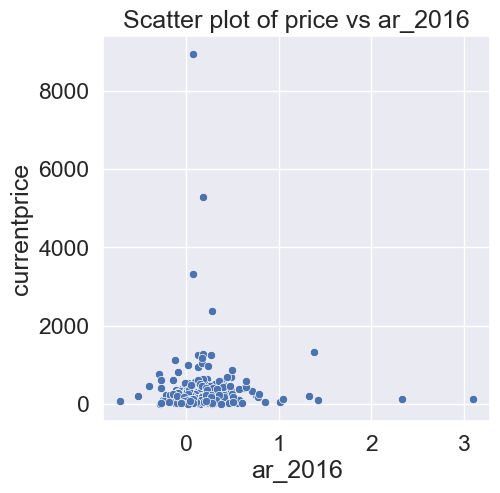

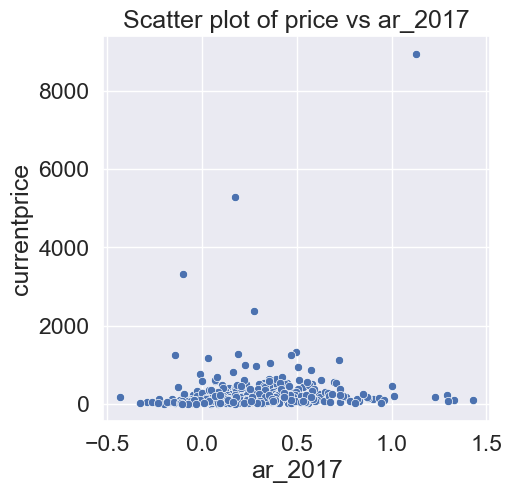

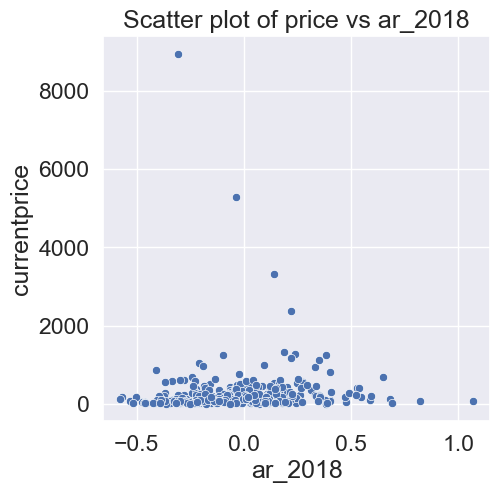

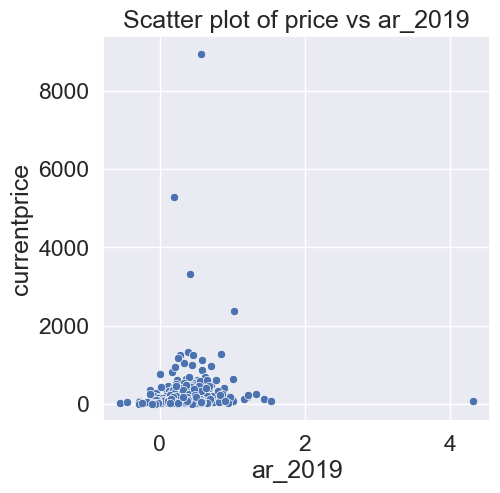

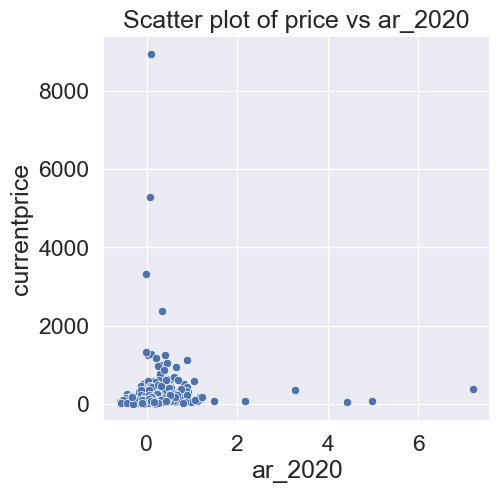

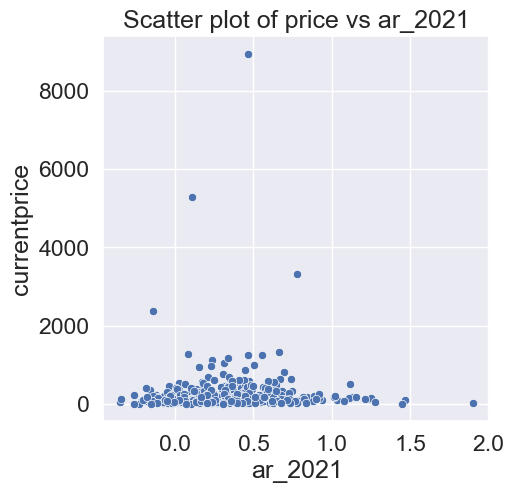

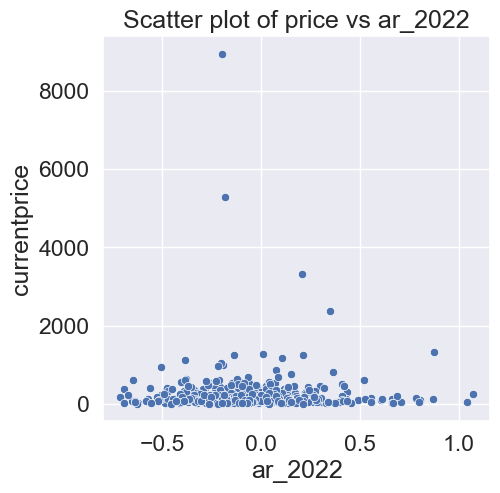

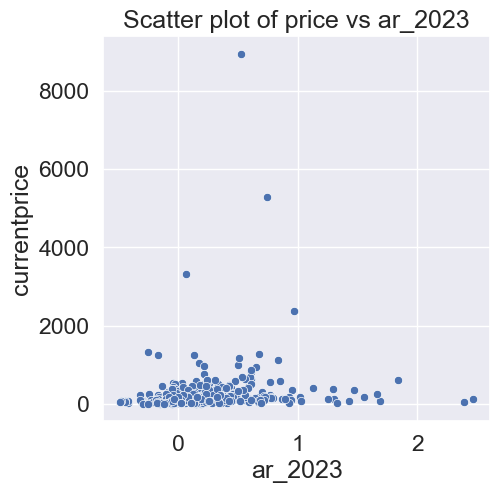

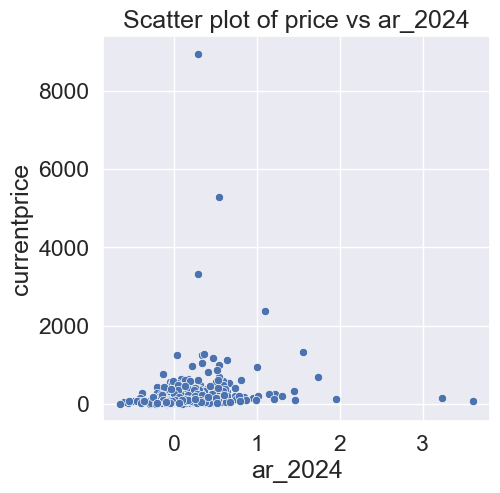

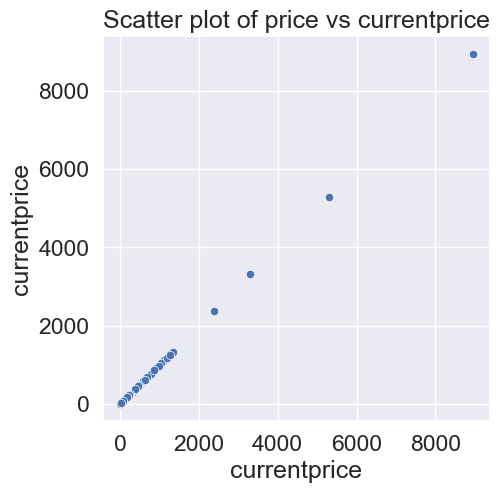

In [47]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=definitive, x=col, y='currentprice')
    plt.show()

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **stock price** based on **sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean stock prices between sectors such as at **Technolgies**, **Industrials**, and **Finance** companies.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
# Extract salaries for Data Scientists by company size
df_small = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Small")]["salary_in_usd"]
df_medium = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Medium")]["salary_in_usd"]
df_large = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Large")]["salary_in_usd"]

In [1]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_small, df_medium, df_large)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company size has no significant impact on data scientist salaries.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in salaries based on company size.")

NameError: name 'st' is not defined

<h2 style="color: #9370DB;"> 04 | Data Processing </h2>

<h3 style="color: #4169E1;"> 4.1 | X-Y Split</h3>

<h3 style="color: #4169E1;"> 4.2 | Selecting the Model</h3>

<h4 style="color: #00BFFF;"> 4.2.1 | Selecting Model: Linear Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.2 | Selecting Model: Ridge Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.3 | Selecting Model: Lasso Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.4 | Selecting Model: Decision Tree Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.5 | Selecting Model: KNN Regression </h4>

<h4 style="color: #00BFFF;"> 4.2.6 | Selecting Model: XGBoost Regression </h4>

<h3 style="color: #4169E1;"> 4.3 | Final Comparision</h3>

<h2 style="color: #9370DB;"> 05 | Improving Model </h2>

<h3 style="color: #4169E1;"> 5.1 | Normalization with MinMaxScaler</h3>

<h3 style="color: #4169E1;"> 5.2 | Standardization with StandardScaler</h3>

<h3 style="color: #4169E1;"> 5.3 | Normzalization with Long Transform</h3>

<h3 style="color: #4169E1;"> 5.4 | Feature Engineering </h3>

<h2 style="color: #9370DB;"> 06 | Reporting </h2>